In [3]:
import xml.etree.ElementTree as ET
import os
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform, cosine, euclidean
import umap

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report

from sklearn_extra.cluster import KMedoids

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# 1 - read XML

In [4]:
def add_system_elements(root, sys_type, sys_elements, ns):
    col_vals = {}
    for system in root.findall(".//BG:System[@xsi:type='"+sys_type+"']", ns):
         for sub_elem in sys_elements: 
            col_val = system.find("BG:"+sub_elem, ns).attrib["value"]
            col_name = "_".join(["System", sys_type, sub_elem])
            col_vals[col_name] = col_val
            #print(col_name, col_val)
    return col_vals

#UrineProductionRate_mL_Per_min xsi:type="BioGearsRenalSystemData", System
#UrineProductionRate xsi:type="BioGearsRenalSystemData", System
#SkinTemperature xsi:BioGearsEnergySystemData

# <System xsi:type="BioGearsCardiovascularSystemData">, <HeartRate readOnly="false" unit="1/min" value="72.2259599982094"/>
#   <System xsi:type="BioGearsCardiovascularSystemData">, <SystolicArterialPressure readOnly="false" unit="mmHg" value="114.330638012746"/>        
#   <System xsi:type="BioGearsCardiovascularSystemData">, <DiastolicArterialPressure readOnly="false" unit="mmHg" value="73.3082616148189"/>
#   <System xsi:type="BioGearsCardiovascularSystemData">, <CardiacOutput readOnly="false" unit="mL/min" value="5975.89457426133"/>
#   <System xsi:type="BioGearsCardiovascularSystemData">, <SystemicVascularResistance readOnly="false" unit="mmHg s/mL" value="0.912993395707968"/>
#   <System xsi:type="BioGearsCardiovascularSystemData">, <BloodVolume readOnly="false" unit="mL" value="5613.857708257"/>

#     <System xsi:type="BioGearsBloodChemistrySystemData">, <InflammatoryResponse>, <TissueIntegrity readOnly="false" value="0.727975915070117"/>
#   <System xsi:type="BioGearsBloodChemistrySystemData">, <ArterialBloodPH readOnly="false" value="7.45469889061384"/>    

#     <System xsi:type="BioGearsRespiratorySystemData">,    <RespirationRate readOnly="false" unit="1/min" value="24.5901639344262"/>
#   <System xsi:type="BioGearsRespiratorySystemData">,   <TidalVolume readOnly="false" unit="L" value="0.508949820975716"/>

#   <System xsi:type="BioGearsRenalSystemData">,    <MeanUrineOutput readOnly="false" unit="mL/day" value="1796.14878808744"/>

#     <DataRequest DecimalFormat="FixedMantissa" Name="HeartRate" Precision="6" Unit="1/min" xsi:type="PhysiologyDataRequestData"/>
#     <DataRequest DecimalFormat="FixedMantissa" Name="ArterialBloodPH" Precision="6" Unit="unitless" xsi:type="PhysiologyDataRequestData"/>
#     <DataRequest DecimalFormat="FixedMantissa" Name="CardiacOutput" Precision="6" Unit="mL/min" xsi:type="PhysiologyDataRequestData"/>
#     <DataRequest DecimalFormat="FixedMantissa" Name="InflammatoryResponse-TissueIntegrity" Precision="6" xsi:type="PhysiologyDataRequestData"/>
####     <DataRequest DecimalFormat="FixedMantissa" Name="MeanArterialPressure" Precision="6" Unit="mmHg" xsi:type="PhysiologyDataRequestData"/>
#     <DataRequest DecimalFormat="FixedMantissa" Name="SystolicArterialPressure" Precision="6" Unit="mmHg" xsi:type="PhysiologyDataRequestData"/>
#     <DataRequest DecimalFormat="FixedMantissa" Name="DiastolicArterialPressure" Precision="6" Unit="mmHg" xsi:type="PhysiologyDataRequestData"/>
#     <DataRequest DecimalFormat="FixedMantissa" Name="RespirationRate" Precision="6" Unit="1/min" xsi:type="PhysiologyDataRequestData"/>
#     <DataRequest DecimalFormat="FixedMantissa" Name="TidalVolume" Precision="6" Unit="mL" xsi:type="PhysiologyDataRequestData"/>
#     <DataRequest DecimalFormat="FixedMantissa" Name="SystemicVascularResistance" Precision="6" Unit="mmHg s/mL" xsi:type="PhysiologyDataRequestData"/>
#     <DataRequest DecimalFormat="FixedMantissa" Name="BloodVolume" Precision="6" Unit="mL" xsi:type="PhysiologyDataRequestData"/>
#     <DataRequest DecimalFormat="FixedMantissa" Name="MeanUrineOutput" Precision="6" Unit="mL/hr" xsi:type="PhysiologyDataRequestData"/>

In [5]:
#This function reads BioGears XML state files, extracts the relevant elements, and returns a dataframe

def get_patient_dataframes(data_path, diff=1):
    tbsa_hour_delim = "@"
    ringers_albumin_delim = "_"
    patients_df  = pd.DataFrame()
    patients_err_df  = pd.DataFrame()
    ns = {"BG":"uri:/mil/tatrc/physiology/datamodel", "xsi":"http://www.w3.org/2001/XMLSchema-instance"}

    sys_map = {"BioGearsCardiovascularSystemData":["HeartRate", "SystolicArterialPressure", "DiastolicArterialPressure", "CardiacOutput", "SystemicVascularResistance", "BloodVolume"],
              "BioGearsBloodChemistrySystemData":["InflammatoryResponse/BG:TissueIntegrity", "ArterialBloodPH"],
              "BioGearsRespiratorySystemData":["RespirationRate", "TidalVolume"],
              "BioGearsRenalSystemData":["MeanUrineOutput", "UrineProductionRate"],
              "BioGearsEnergySystemData":["SkinTemperature"]}
    
    #loop through the files
    for file_name in os.listdir(data_path):
        if file_name.endswith("xml"):
            #setup some intial vars for each file
            col_vals = {}
            err_col_vals = {}
            hour_token = file_name.split(tbsa_hour_delim)[1]
            hour = hour_token.split("min")[0]
            if len(hour) == 1:
                hour = "0" + hour
            tbsa_token = file_name.split(tbsa_hour_delim)[0]
            tbsa = tbsa_token[:2]
            file_path = os.path.join(data_path,file_name)

            ringers_token = file_name.split(ringers_albumin_delim)[1]
            ringers = ringers_token.split("R")[0]
            
            albumin_token = file_name.split(ringers_albumin_delim)[2]
            albumin = albumin_token.split("A")[0]
            
            #Now parse the file
            #TODO this really should be refactored into somehtign more generic
            print("Parsing: " + file_path)            
            tree = ET.parse(file_path)
            root = tree.getroot()

            #get system states
            prefix = "system"
            for tag in root.findall(".//BG:System/*", ns):
                if ( tag.text != None):
                    col_val = tag.text
                    col_name = "_".join([prefix, tag.tag.split("}")[-1]])
                    col_vals[col_name] = col_val
            for pat in root.findall(".//BG:System/*[@value]", ns):
                col_val = pat.attrib["value"]
                col_name = "_".join([prefix, pat.tag.split("}")[-1]])
                col_vals[col_name] = col_val
            
            #get active subtances
            prefix = "active_action"
            for sub in root.findall(".//BG:ActiveAction[@xsi:type='SubstanceCompoundInfusionData']", ns):
                name = sub.find("BG:SubstanceCompound",ns).text
                sub_elements = ["Rate", "BagVolume"]
                for sub_elem in sub_elements:                
                    col_val = sub.find("BG:"+sub_elem,ns).attrib["value"]
                    col_name = "_".join([prefix, name, sub_elem])
                    col_vals[col_name] = col_val
            
            #get active subtances
            prefix = "active_substance"
            for sub in root.findall(".//BG:ActiveSubstance", ns):
                name = sub.find("BG:Name",ns).text
                state = sub.find("BG:State",ns).text
                for tag in sub.findall(".//*[@value]", ns):
                    col_val = tag.attrib["value"]
                    col_name = "_".join([prefix, name, state,tag.tag.split("}")[-1]])
                    col_vals[col_name] = col_val

            #get circuit manager -TODO REFACTOR to loop
            prefix = "circuit_manager_fluid_node"
            for sub in root.findall(".//BG:CircuitManager/BG:FluidNode", ns):
                name = sub.find("BG:Name",ns).text
                for tag in sub.findall("./*[@value]", ns):
                    col_val = tag.attrib["value"]
                    col_name = "_".join([prefix, name, tag.tag.split("}")[-1]])
                    col_vals[col_name] = col_val

            prefix = "circuit_manager_fluid_path"
            for sub in root.findall(".//BG:CircuitManager/BG:FluidPath", ns):
                name = sub.find("BG:Name",ns).text
                for tag in sub.findall("./*[@value]", ns):
                    col_val = tag.attrib["value"]
                    col_name = "_".join([prefix, name, tag.tag.split("}")[-1]])
                    col_vals[col_name] = col_val

            prefix = "circuit_manager_thermal_node"
            for sub in root.findall(".//BG:CircuitManager/BG:ThermalNode", ns):
                name = sub.find("BG:Name",ns).text
                for tag in sub.findall("./*[@value]", ns):
                    col_val = tag.attrib["value"]
                    col_name = "_".join([prefix, name, tag.tag.split("}")[-1]])
                    col_vals[col_name] = col_val

            prefix = "circuit_manager_thermal_path"
            for sub in root.findall(".//BG:CircuitManager/BG:ThermalPath", ns):
                name = sub.find("BG:Name",ns).text
                for tag in sub.findall("./*[@value]", ns):
                    col_val = tag.attrib["value"]
                    col_name = "_".join([prefix, name, tag.tag.split("}")[-1]])
                    col_vals[col_name] = col_val

            #compartment manager TODO refactor into loop
            prefix = "compartment_manager_gas_compartment"
            for sub in root.findall(".//BG:CompartmentManager/BG:GasCompartment", ns):
                name = sub.find("BG:Name",ns).text
                for tag in sub.findall("./*[@value]", ns):
                    col_val = tag.attrib["value"]
                    col_name = "_".join([prefix, name, tag.tag.split("}")[-1]])
                    col_vals[col_name] = col_val

                for tag in sub.findall("./BG:SubstanceQuantity", ns):
                    name2 = tag.find("BG:Substance",ns).text
                    for tag2 in tag.findall("./*[@value]", ns):
                        col_val = tag2.attrib["value"]
                        col_name = "_".join([prefix, name, name2, tag2.tag.split("}")[-1]])
                        col_vals[col_name] = col_val

            prefix = "compartment_manager_liquid_compartment"
            for sub in root.findall(".//BG:CompartmentManager/BG:LiquidCompartment", ns):
                name = sub.find("BG:Name",ns).text

                for tag in sub.findall("./*[@value]", ns):
                    col_val = tag.attrib["value"]
                    col_name = "_".join([prefix, name, tag.tag.split("}")[-1]])
                    col_vals[col_name] = col_val

                for tag in sub.findall("./BG:SubstanceQuantity", ns):
                    name2 = tag.find("BG:Substance",ns).text
                    for tag2 in tag.findall("./*[@value]", ns):
                        col_val = tag2.attrib["value"]
                        col_name = "_".join([prefix, name, name2, tag2.tag.split("}")[-1]])
                        col_vals[col_name] = col_val

            prefix = "compartment_manager_thermal_compartment"
            for sub in root.findall(".//BG:CompartmentManager/BG:ThermalCompartment", ns):
                name = sub.find("BG:Name",ns).text
                for tag in sub.findall("./*[@value]", ns):
                    col_val = tag.attrib["value"]
                    col_name = "_".join([prefix, name, tag.tag.split("}")[-1]])
                    col_vals[col_name] = col_val

            prefix = "compartment_manager_tissue_compartment"
            for sub in root.findall(".//BG:CompartmentManager/BG:TissueCompartment", ns):
                name = sub.find("BG:Name",ns).text
                for tag in sub.findall("./*[@value]", ns):
                    col_val = tag.attrib["value"]
                    col_name = "_".join([prefix, name, tag.tag.split("}")[-1]])
                    col_vals[col_name] = col_val

            prefix = "compartment_manager_liquid_link"
            for sub in root.findall(".//BG:CompartmentManager/BG:LiquidLink", ns):
                name = sub.find("BG:Name",ns).text
                for tag in sub.findall("./*[@value]", ns):
                    col_val = tag.attrib["value"]
                    col_name = "_".join([prefix, name, tag.tag.split("}")[-1]])
                    col_vals[col_name] = col_val

            prefix = "compartment_manager_gas_link"
            for sub in root.findall(".//BG:CompartmentManager/BG:GasLink", ns):
                name = sub.find("BG:Name",ns).text
                for tag in sub.findall("./*[@value]", ns):
                    col_val = tag.attrib["value"]
                    col_name = "_".join([prefix, name, tag.tag.split("}")[-1]])
                    col_vals[col_name] = col_val

            prefix = "compartment_manager_thermal_link"
            for sub in root.findall(".//BG:CompartmentManager/BG:ThermalLink", ns):
                name = sub.find("BG:Name",ns).text
                for tag in sub.findall("./*[@value]", ns):
                    col_val = tag.attrib["value"]
                    col_name = "_".join([prefix, name, tag.tag.split("}")[-1]])
                    col_vals[col_name] = col_val

            print("Features extracted: " + str(len(col_vals)))
            patient_df = pd.DataFrame( data = [ list(col_vals.values())], columns = list(col_vals.keys()) )
            patient_df["mins"] = hour
            patient_df["tbsa"] = tbsa
            patient_df["ringers"] = ringers
            patient_df["albumin"] = albumin
            patient_df["tbsa_mins"] = "_".join([str(tbsa), str(hour)])
            patients_df = pd.concat([patients_df, patient_df])

            #get error function dataframes
            for sys_type, sys_elements in sys_map.items():
                new_cols = add_system_elements(root, sys_type, sys_elements, ns)
                err_col_vals = {**err_col_vals, **new_cols}
            print("Error Features extracted: " + str(len(err_col_vals)))
            patient_err_df = pd.DataFrame( data = [ list(err_col_vals.values())], columns = list(err_col_vals.keys()) )
            patient_err_df["mins"] = hour
            patient_err_df["tbsa"] = tbsa
            patient_err_df["ringers"] = ringers
            patient_err_df["albumin"] = albumin
            patient_err_df["tbsa_mins"] = "_".join([str(tbsa), str(hour)])
            patients_err_df = pd.concat([patients_err_df, patient_err_df])
                
    print("Cleaning up...")
    
    #Drop text composite elements we picked up by accident
    patients_clean = patients_df.replace("\n      ", np.nan).dropna(axis=1)

    #Cast datatypes from object/srting to floats
    for col in patients_clean.columns[:-3]:
        try:
            patients_clean[col] = patients_clean[col].astype(float)
        except ValueError:
            #patients_clean[col] = patients_clean[col].astype("category")#.cat.categories
            patients_clean[col] = pd.Categorical(patients_clean[col]).codes.astype(float)
            pass

    return patients_clean, patients_err_df

# 2 - get distance matrix

In [6]:
def get_distance_matrix(patients_df):
    #scale patient values
    scaler = StandardScaler()
    patients_df = patients_df.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

    #don't include hour, tbsa, or tbsa_hour columns
    scaler.fit(patients_df.iloc[:,0:-5])
    patients_scaled = scaler.transform(patients_df.iloc[:,0:-5])
    cosine_dists = pdist(patients_scaled, cosine)
    patient_cosine = pd.DataFrame(squareform(cosine_dists), columns=patients_df["tbsa_mins"].values, index=patients_df["tbsa_mins"].values)

    patient_cosine = patient_cosine[sorted(patient_cosine.columns)]
    patient_cosine = patient_cosine.sort_index()

    fig, ax = plt.subplots(figsize=(11, 9))
    mask = np.triu(np.ones_like(patient_cosine, dtype=bool))
    cmap = sns.diverging_palette(20, 230, as_cmap=True)
    sns.set(style='white', font_scale = 1.0)
    sns_ax = sns.heatmap(patient_cosine, mask=mask, cmap=cmap)#, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
    sns_ax.set_xlabel('Hourly Patient States (TBSA_hour)',fontsize=15)
    sns_ax.set_ylabel('Hourly Patient States (TBSA_hour)',fontsize=15)
    #sns_ax.set_title("Cosine Distance Between Hourly Patient States",fontsize=20)
    #fig.savefig("tbsa_embedding_hourly_euclidean_distance_lower_tri", dpi=400)
    
    return patients_scaled, patient_cosine

# 3 - assign labels

In [7]:
def get_cluster_labels(patients_df, k_clusters):
    labels = KMeans(n_clusters=k_clusters).fit_predict(patients_df)

    return labels

# 4 - learn embedding

In [8]:
def get_shifted_df(matrix, tbsa_col, max_lag, col_names):
#    max_lag = 3
    shift_df = pd.DataFrame()
#    suffix_cols = features_sme_df.columns[:-5]#[str(int) for int in np.arange(0,embedding_dim)]

    for n_lag in np.arange(1,max_lag+1):
        lag_cols = ["_"+str(n_lag)+"_lag"]*len(col_names)
        shift_cols = [col_name + lag_col for lag_col,col_name in zip(lag_cols,col_names)]
        cur_shift = pd.DataFrame(matrix, columns=shift_cols)
        cur_shift["tbsa"] = tbsa_col
        cur_shift = cur_shift.iloc[:, :-1].shift(n_lag).where(cur_shift.tbsa.eq(cur_shift.tbsa.shift(n_lag)))
        shift_df = pd.concat([shift_df, cur_shift], axis=1)
    return shift_df

In [9]:
def get_trend_df(matrix, tbsa_col, max_lag, col_names):
    trend_df = pd.DataFrame()

    for n_lag in np.arange(1,max_lag+1):
        lag_cols = ["_"+str(n_lag)+"_trend"]*len(col_names)
        trend_cols = [col_name + lag_col for lag_col,col_name in zip(lag_cols,col_names)]
        cur_trend = pd.DataFrame(matrix, columns=trend_cols)
        cur_trend["tbsa"] = tbsa_col
        cur_trend = cur_trend.iloc[:, :-1].diff(periods=int(n_lag)).where(cur_trend.tbsa.eq(cur_trend.tbsa.shift(n_lag)))
        trend_df = pd.concat([trend_df, cur_trend], axis=1)
    return trend_df

In [10]:
def get_trained_metric(X_train, y_train, n_neighbors, embedding_dim, embed_metric):
    reducer = umap.UMAP(n_neighbors=n_neighbors, n_components=embedding_dim, metric=embed_metric)
    mapper = reducer.fit(X_train, y_train)
    
    return mapper

# 5 - classification model

In [197]:
def get_predictions_no_prob(clf, X, y, ids, n_splits=4):
    skf = StratifiedKFold(n_splits=n_splits)
    #skf = KFold(n_splits=n_splits)
    skf.get_n_splits(X, y)
    num_targets = len(np.unique(y))

    cm = np.zeros((num_targets, num_targets))
    #neigh = KNeighborsClassifier(n_neighbors=3)
    pred_df = pd.DataFrame()
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)

        y_hat = clf.predict(X_test)
        
        cm += confusion_matrix(y_test, y_hat)
        y_hat_df = pd.DataFrame(index=test_index, data=y_hat, columns= ["y_hat"])
        y_hat_df = pd.concat([ids.iloc[test_index, :],y_hat_df], axis=1)
        pred_df = pd.concat([pred_df, y_hat_df])

    return pred_df.sort_values(by=["tbsa", "mins"]), cm

In [11]:
def get_predictions(clf, X, y, ids, n_splits=4):
    skf = StratifiedKFold(n_splits=n_splits)
    #skf = KFold(n_splits=n_splits)
    skf.get_n_splits(X, y)
    num_targets = len(np.unique(y))

    cm = np.zeros((num_targets, num_targets))
    #neigh = KNeighborsClassifier(n_neighbors=3)
    pred_df = pd.DataFrame()
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)

        y_hat = clf.predict(X_test)
        y_hat_p = clf.predict_proba(X_test)
        y_all = np.concatenate((y_hat_p, y_hat.reshape(y_hat.shape[0],1)), axis=1)
        
        class_cols = ["py_"]*num_targets
        suffix_cols = [str(int) for int in np.arange(0,num_targets)]
        cols = [class_col + suffix_col for class_col,suffix_col in zip(class_cols,suffix_cols)]
        
        cm += confusion_matrix(y_test, y_hat)
        y_hat_df = pd.DataFrame(index=test_index, data=y_all, columns=cols + ["y_hat"])
        y_hat_df = pd.concat([ids.iloc[test_index, :],y_hat_df], axis=1)
        pred_df = pd.concat([pred_df, y_hat_df])

    return pred_df.sort_values(by=["tbsa", "mins"]), cm

# 6 - Evaluation

In [12]:
def get_confusion_matrix(cm, display_labels):
    fig, ax = plt.subplots(1, figsize=(11, 9))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(ax=ax)
    return disp

In [13]:
def eval_heat_map(X_tra, num_extra_cols, y, annot=None):
    y_col_name = y.name
    df = pd.concat([X_tra,y], axis=1)
    df_pivot = df.pivot(index="tbsa", columns="mins", values=y_col_name)
    
#    annot = np.asarray(['x']*(21*96)).reshape(21,96)
    
    sns.set(style='white', context='poster')
    fig, ax = plt.subplots(1, figsize=(18, 9))

    if annot is None:
        sns.heatmap(ax=ax, data=df_pivot, linewidths=.1)
    else:
        annot_col_name = annot.name
        df = pd.concat([X_tra,annot], axis=1)
        df_annot = df.pivot(index="tbsa", columns="mins", values=annot_col_name)
        sns.heatmap(ax=ax, data=df_pivot, linewidths=.1, annot=df_annot, fmt="")

    ax.set_title(y_col_name.title())
    
    return df_pivot

In [206]:
def run_eval(X, y, X_tra, clf, n_splits=6, proba=True):
    display_labels=["Init", "Mild", "Moderate", "Severe", "Deadly"]

    if(proba):
        pred_df, cm = get_predictions(clf, X, y, X_tra[["tbsa", "mins"]], n_splits)
    else:
        pred_df, cm = get_predictions_no_prob(clf, X, y, X_tra[["tbsa", "mins"]], n_splits)
    #7 - eval: heatmaps, confusion, metrics
    pred_df["y"] = y
    pred_df["y_diff"] = (pred_df["y"]+1)-(pred_df["y_hat"]+1)#pred_df["y"]-pred_df["y_hat"]
    pred_df["y_diff_str"] = np.where(pred_df["y_diff"]==0, "", "x")
    pivot_hm_df = eval_heat_map(X_tra, num_extra_cols, pred_df["y"], pred_df["y_diff_str"])

    cm_disp = get_confusion_matrix(cm, display_labels)

    report = classification_report(y, pred_df["y_hat"], target_names=display_labels)
    print(report)
    
    return pred_df, report

# Main function

In [55]:
if __name__ == "__main__":
    main()

NameError: name 'main' is not defined

# load data, scale

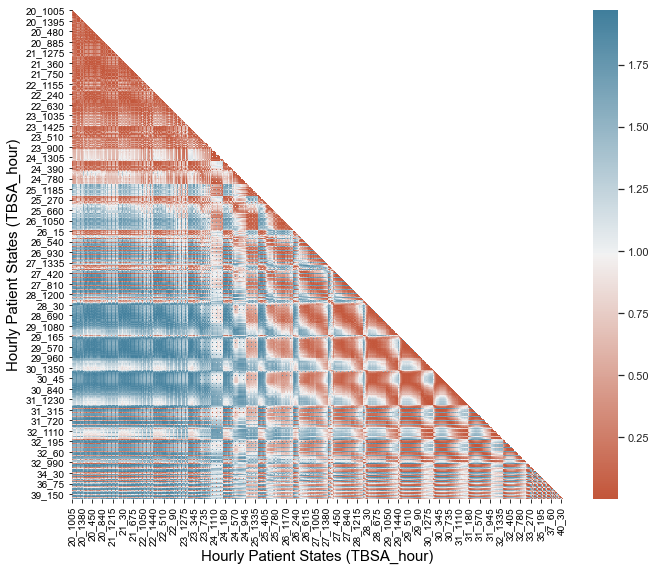

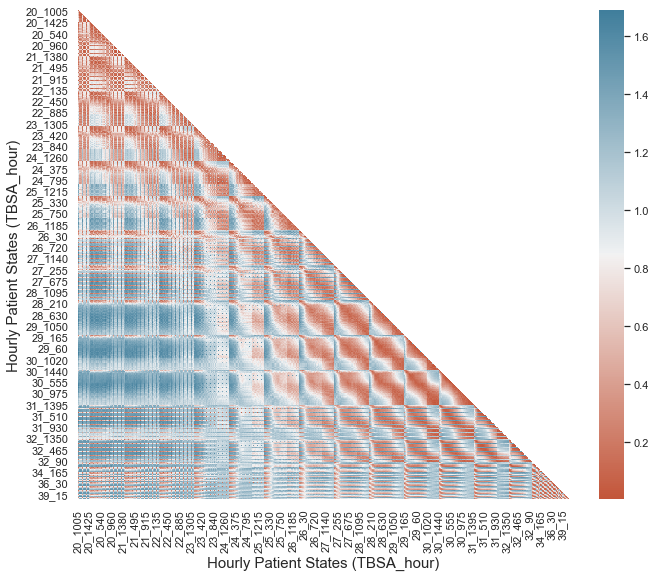

In [70]:
#1 - extract XML or load csvs (all, SME)
#Only need to do this once
# data_path = "../../../data/fluids_20_40"
# features_all_df, features_sme_df = get_patient_dataframes(data_path, diff=1)

#features_all_df_sorted = features_all_df.sort_values(by=["tbsa","mins"])
#features_sme_df.sort_values(by=["tbsa","mins"], inplace=True)
#features_all_df_sorted.to_csv("20_40_tbsa_15_min_ringers_features_all.csv", index=False)
#features_sme_df.to_csv("20_40_tbsa_15_min_ringers_features_error.csv", index=False)

features_all_df = pd.read_csv("../data/20_40_tbsa_15_min_ringers_features_all.csv")
features_sme_df = pd.read_csv("../data/20_40_tbsa_15_min_ringers_features_sme.csv")

test_tbsa =  pd.read_csv("../data/patients_TBSA_10_40.csv").drop(['Unnamed: 0'], axis=1)
test_tbsa.rename(columns={"hour":"mins"}, inplace=True)
tbsa_hours = test_tbsa.pop("tbsa_hour")
test_tbsa["mins"] = test_tbsa["mins"].multiply(60)
test_tbsa["ringers"] = 0
test_tbsa["albumin"] = 0
test_tbsa["tbsa_mins"] = test_tbsa["tbsa"].astype(str) + "_" + test_tbsa["mins"].astype(str)

#2 - get scaled data (all, sme)
ids_df = features_sme_df.iloc[:,-5:]
scaled_sme_mat, scaled_sme_dm = get_distance_matrix( features_sme_df )
scaled_all_mat, scaled_all_dm = get_distance_matrix( features_all_df )

In [74]:
k_cluster = 5
kmed = KMedoids(metric="euclidean", n_clusters=k_cluster)
sme_scaled_labels_kmed = kmed.fit_predict(scaled_sme_mat)

# feature engineering, labels

In [ ]:
# tbsa_embedding_mat = get_trained_metric(X_train, y_train, embedding_neighbors, embedding_dim, embed_metric)
# umap.UMAP(n_neighbors=5, n_components=embedding_dim, metric=embed_metric).fit_transform(scaled_all_mat)
# tbsa_embedding_df = pd.DataFrame(tbsa_embedding_mat, columns=embedding_cols)

In [89]:
#scaled_sme_df = pd.DataFrame(data=scaled_sme_mat, columns=features_sme_df.columns[:-5])


#3 - get labels/represeantative BG state files (embedding, sme, scaled_SME),(k=4,5,6) == heatmaps
k_cluster = 5
sme_scaled_labels_kmeans = get_cluster_labels(scaled_sme_mat, k_cluster)
sme_labels_kmeans = get_cluster_labels(features_sme_df.iloc[:,:-5], k_cluster)

kmed = KMedoids(metric="euclidean", n_clusters=k_cluster)
sme_scaled_labels_kmed = kmed.fit_predict(scaled_sme_mat)
sme_scaled_centroids = kmed.cluster_centers_
    
sme_labels_kmed = kmed.fit_predict(features_sme_df.iloc[:,:-5])
sme_scaled_centroids = kmed.cluster_centers_

#embed patient data, setup params and col names
embed_metric = 'cosine'
embedding_dim = 2
embedding_neighbors=5
prefix_cols = ["umap_"]*embedding_dim
suffix_cols = [str(int) for int in np.arange(0,embedding_dim)]
embedding_cols = [prefix+suffix for prefix,suffix in zip(prefix_cols,suffix_cols)]

patient_embedding_mat = umap.UMAP(n_neighbors=embedding_neighbors, n_components=embedding_dim, metric=embed_metric).fit_transform(scaled_all_mat)
patient_embedding_df = pd.DataFrame(patient_embedding_mat, columns=embedding_cols)

#5 - get lagging features
#get differece between current time and 1,2,3,4 previsou timseteps
scaled_sme_trend_df = get_trend_df(scaled_sme_mat, features_sme_df["tbsa"], 4, features_sme_df.columns[:-5])
sme_trend_df = get_trend_df(features_sme_df.iloc[:,:-5].to_numpy(), features_sme_df["tbsa"], 4, features_sme_df.columns[:-5])

#only use the difference from previous 2 timsteps (30 mins)
scaled_sme_shift_df = scaled_sme_trend_df.filter(regex="_2_trend$")
sme_shift_df = sme_trend_df.filter(regex="_2_trend$")

#and then shift it by 4 intervals (60 mins) so we have now have leading trend indicators and can predict 4 intevals in advance 
scaled_sme_lead_trend_df = get_shifted_df(scaled_sme_shift_df.to_numpy(), features_sme_df["tbsa"], 4, scaled_sme_shift_df.columns)
sme_lead_trend_df = get_shifted_df(sme_shift_df.to_numpy(), features_sme_df["tbsa"], 4, sme_shift_df.columns)
#6 - baseline approaches below

# KMED AS CLASSifer

              precision    recall  f1-score   support

        Init       0.87      0.85      0.86       363
        Mild       1.00      0.98      0.99       207
    Moderate       0.73      0.76      0.75       258
      Severe       0.85      0.84      0.85       269
      Deadly       0.90      0.92      0.91       252

    accuracy                           0.86      1349
   macro avg       0.87      0.87      0.87      1349
weighted avg       0.87      0.86      0.86      1349



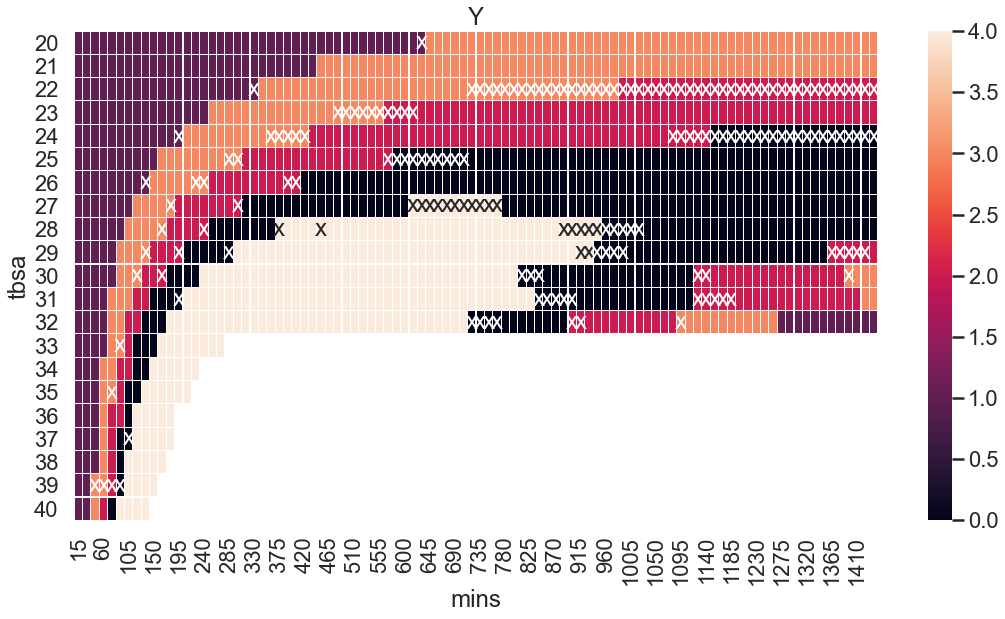

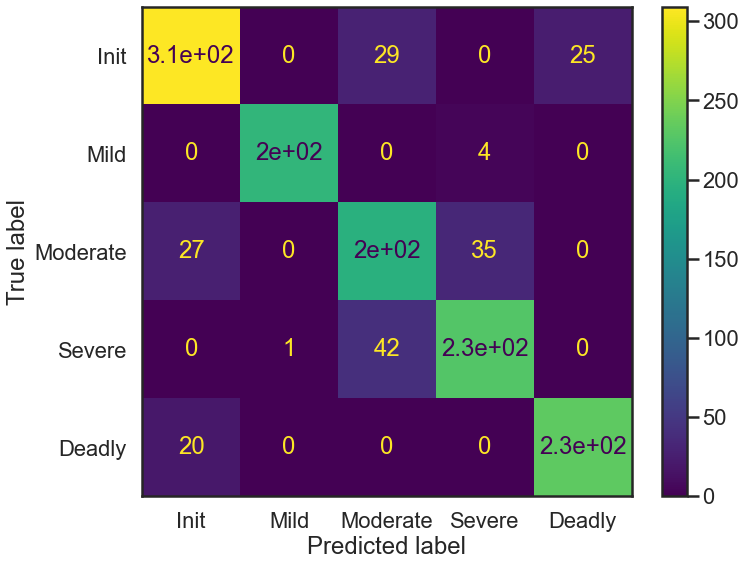

In [208]:
clf = KNeighborsClassifier(n_neighbors=3)
X = pd.concat([features_sme_df.iloc[:,:-5],ids_df["ringers"]], axis=1)
X_tra = pd.concat([X, ids_df], axis=1)
num_extra_cols = ids_df.shape[1]
y = sme_labels_kmeans

num_extra_cols = ids_df.shape[1]
#y = sme_labels_kmed_lag
y = sme_labels_kmed[X.index]
X = X.reset_index(drop=True)
pred_df = run_eval(X, y, X_tra, clf, 2, False)

# Simple baseline - Kmediods to select BG states files

              precision    recall  f1-score   support

        Init       0.93      0.88      0.90       363
        Mild       1.00      0.98      0.99       207
    Moderate       0.82      0.84      0.83       258
      Severe       0.86      0.90      0.88       269
      Deadly       0.92      0.94      0.93       252

    accuracy                           0.90      1349
   macro avg       0.91      0.91      0.91      1349
weighted avg       0.90      0.90      0.90      1349



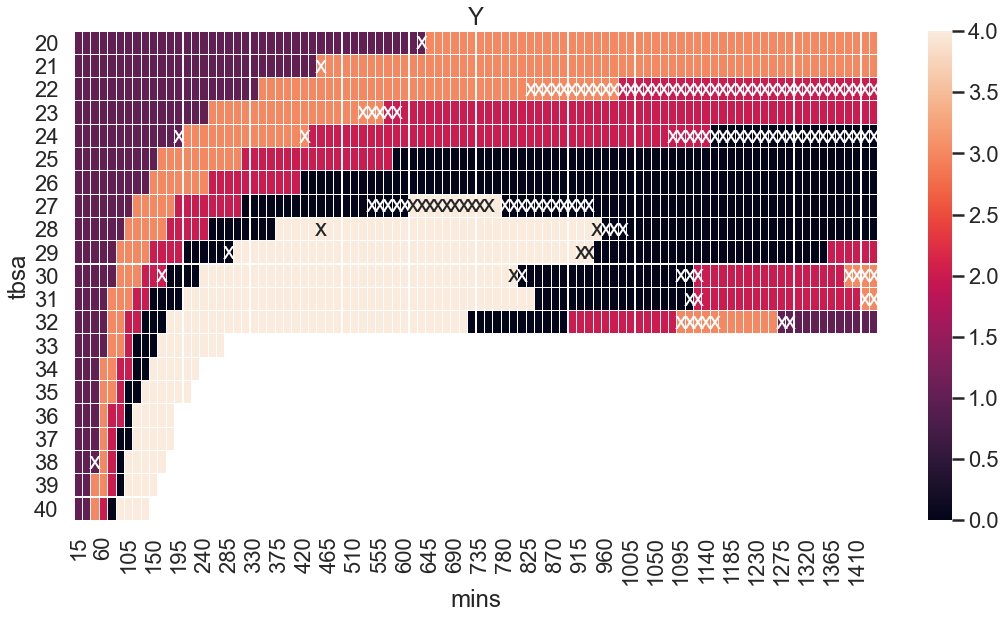

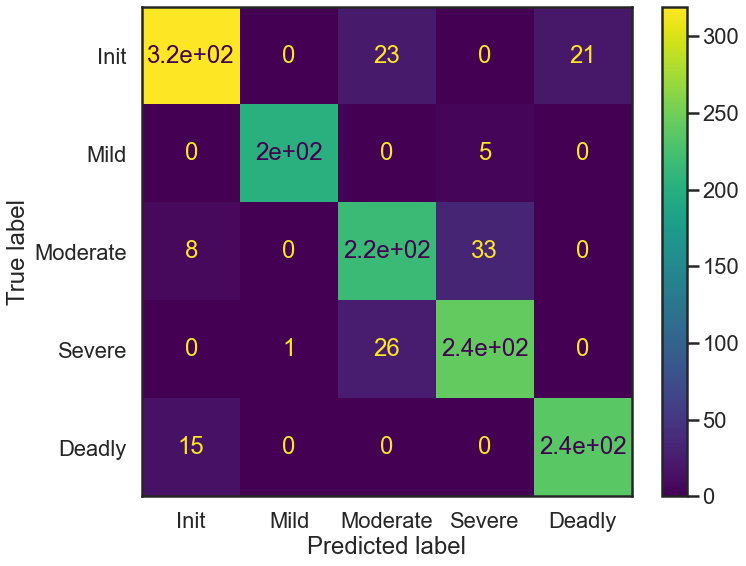

In [212]:
clf = KNeighborsClassifier(n_neighbors=3)
X = features_sme_df.iloc[:,:-5]
X_tra = pd.concat([X, ids_df], axis=1)
num_extra_cols = ids_df.shape[1]
y = sme_labels_kmed

pred_df, report = run_eval(X, y, X_tra, clf)

# Simple baseline - Kmedoids, predict 1 hour ahead with scaled sme features

              precision    recall  f1-score   support

        Init       0.18      0.09      0.12       359
        Mild       0.20      0.10      0.13       112
    Moderate       0.13      0.12      0.12       250
      Severe       0.43      0.55      0.49       251
      Deadly       0.29      0.51      0.37       251

    accuracy                           0.28      1223
   macro avg       0.25      0.27      0.25      1223
weighted avg       0.25      0.28      0.25      1223



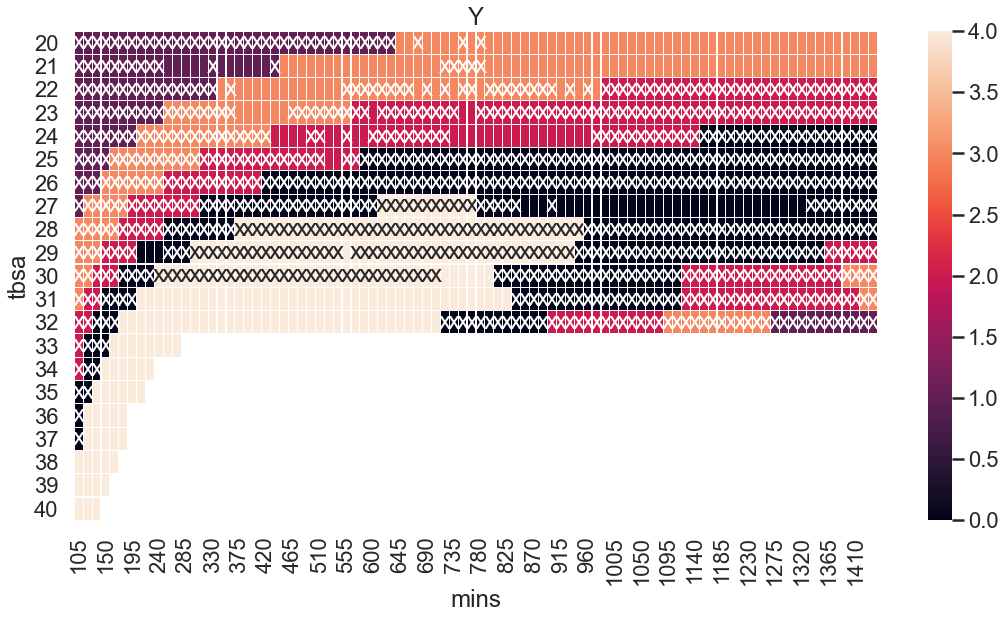

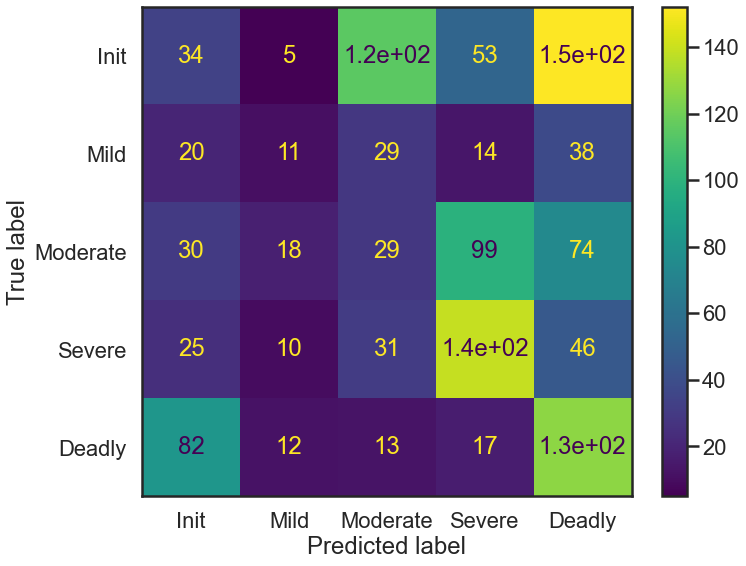

In [213]:
sme_lag_df = scaled_sme_lead_trend_df
clf = KNeighborsClassifier(n_neighbors=3)
X = pd.concat([sme_lag_df.filter(regex="4_lag$"),ids_df["ringers"]], axis=1)#.dropna()
X_tra = pd.concat([X, ids_df], axis=1).dropna().reset_index(drop=True)
X = X.dropna()#.reset_index(drop=True)
num_extra_cols = ids_df.shape[1]
y = sme_labels_kmed[X.index]
X = X.reset_index(drop=True)
pred_df = run_eval(X, y, X_tra, clf, 2)

# Simple baseline - Kmedoids, predict 1 hour ahead with SME features

              precision    recall  f1-score   support

        Init       0.24      0.10      0.14       359
        Mild       0.47      0.60      0.53       112
    Moderate       0.28      0.25      0.27       250
      Severe       0.41      0.37      0.39       251
      Deadly       0.32      0.60      0.42       251

    accuracy                           0.34      1223
   macro avg       0.34      0.39      0.35      1223
weighted avg       0.32      0.34      0.31      1223



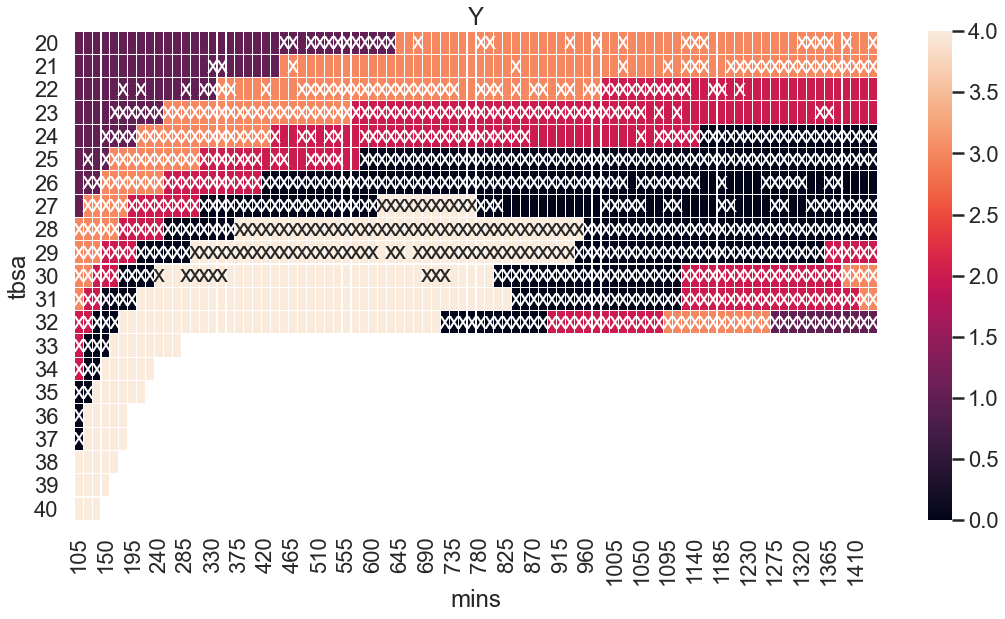

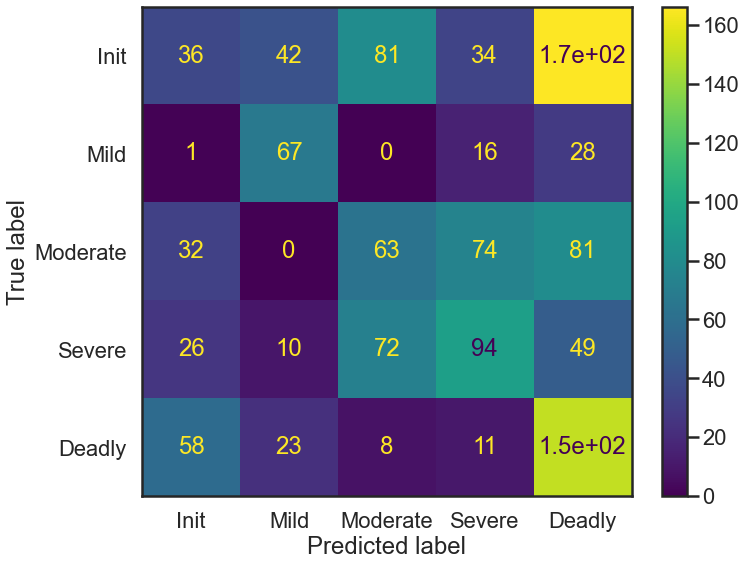

In [210]:
sme_lag_df = sme_lead_trend_df

clf = KNeighborsClassifier(n_neighbors=3)
X = pd.concat([sme_lag_df.filter(regex="4_lag$"),ids_df["ringers"]], axis=1)
#X = sme_lag_df.filter(regex="4_lag$")
X_tra = pd.concat([X, ids_df], axis=1).dropna().reset_index(drop=True)
X = X.dropna()#.reset_index(drop=True)
sme_labels_kmed_lag = kmed.fit_predict(X)
sme_scaled_centroids_lag = kmed.cluster_centers_

num_extra_cols = ids_df.shape[1]
#y = sme_labels_kmed_lag
y = sme_labels_kmed[X.index]
X = X.reset_index(drop=True)
pred_df = run_eval(X, y, X_tra, clf, 2)

# Sequence model: LSTM (NOTE: not expecting to do well here, just PoC)

In [143]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [187]:
tf.keras.backend.clear_session()

lstm_model = keras.Sequential()

X_df = pd.concat([features_sme_df[(features_sme_df["tbsa"] < 33)].iloc[:,:-5],ids_df["ringers"]], axis=1).dropna()
X_tra_df = pd.concat([X_df, ids_df], axis=1)
num_extra_cols = ids_df.shape[1]
y_df = sme_labels_kmeans[X_df.index]

#lstm_model.add(Masking(mask_value=0., input_shape=(timesteps, features)))

# Add a LSTM layer with seq_len internal units.
lstm_model.add(layers.LSTM(16, return_sequences=True))
lstm_model.add(layers.LSTM(16, return_sequences=True))
lstm_model.add(layers.LSTM(16, return_sequences=True))

# Add a Dense layer with 5 units [stable, unstable].
lstm_model.add(layers.Dense(5, activation='softmax'))

lstm_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])

Epoch 1/10
13/13 [==============================] - 0s 33ms/step - loss: 1.5458 - accuracy: 0.3389
Epoch 2/10
13/13 [==============================] - 0s 30ms/step - loss: 1.5435 - accuracy: 0.3462
Epoch 3/10
13/13 [==============================] - 0s 32ms/step - loss: 1.5330 - accuracy: 0.3518
Epoch 4/10
13/13 [==============================] - 0s 31ms/step - loss: 1.5266 - accuracy: 0.3614
Epoch 5/10
13/13 [==============================] - 0s 30ms/step - loss: 1.5155 - accuracy: 0.3694
Epoch 6/10
13/13 [==============================] - 0s 29ms/step - loss: 1.5493 - accuracy: 0.3542
Epoch 7/10
13/13 [==============================] - 0s 29ms/step - loss: 1.5007 - accuracy: 0.3790
Epoch 8/10
13/13 [==============================] - 0s 29ms/step - loss: 1.5111 - accuracy: 0.3750
Epoch 9/10
13/13 [==============================] - 0s 30ms/step - loss: 1.4933 - accuracy: 0.3734
Epoch 10/10
13/13 [==============================] - 0s 31ms/step - loss: 1.5065 - accuracy: 0.3582


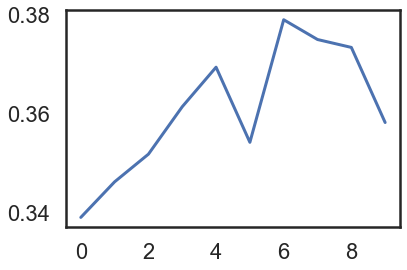

In [211]:
X = X_df.to_numpy().reshape((13,96,14))
y = y_df.reshape((13,96))
history = lstm_model.fit(X, y, epochs=10, batch_size=1)
plt.plot(history.history['accuracy'])

In [186]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, 96, 16)               1984      
_________________________________________________________________
lstm_1 (LSTM)                (1, 96, 16)               2112      
_________________________________________________________________
dense (Dense)                (1, 96, 5)                85        
Total params: 4,181
Trainable params: 4,181
Non-trainable params: 0
_________________________________________________________________


# OLD STUFF below here

# Simple baseline - Kmeans to select BG states files

              precision    recall  f1-score   support

        Init       0.82      0.94      0.87       259
        Mild       0.88      0.95      0.92       266
    Moderate       0.92      0.90      0.91       340
      Severe       0.97      0.93      0.95       198
      Deadly       0.94      0.79      0.86       286

    accuracy                           0.90      1349
   macro avg       0.91      0.90      0.90      1349
weighted avg       0.90      0.90      0.90      1349



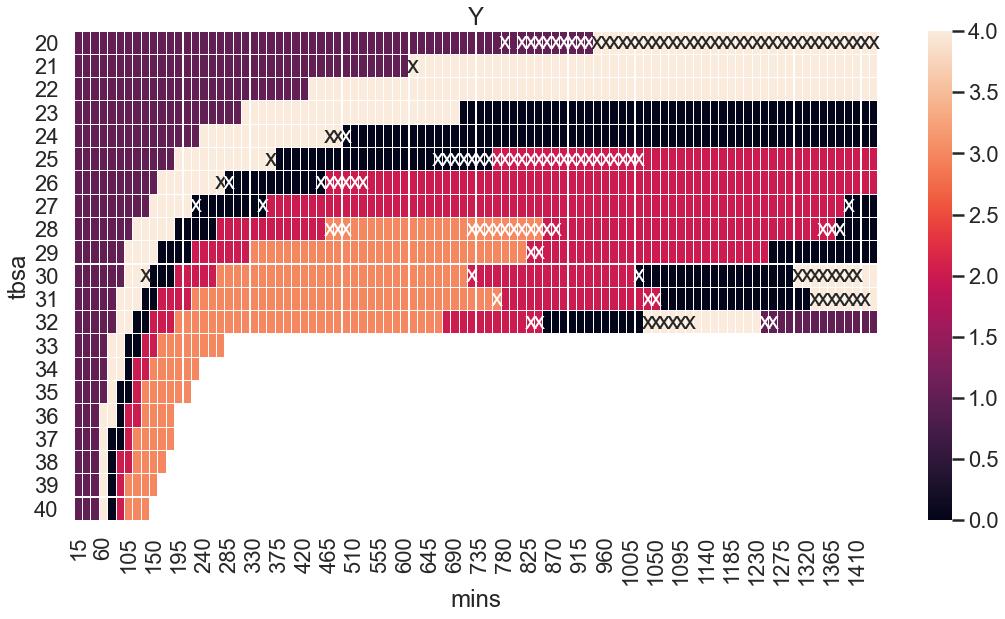

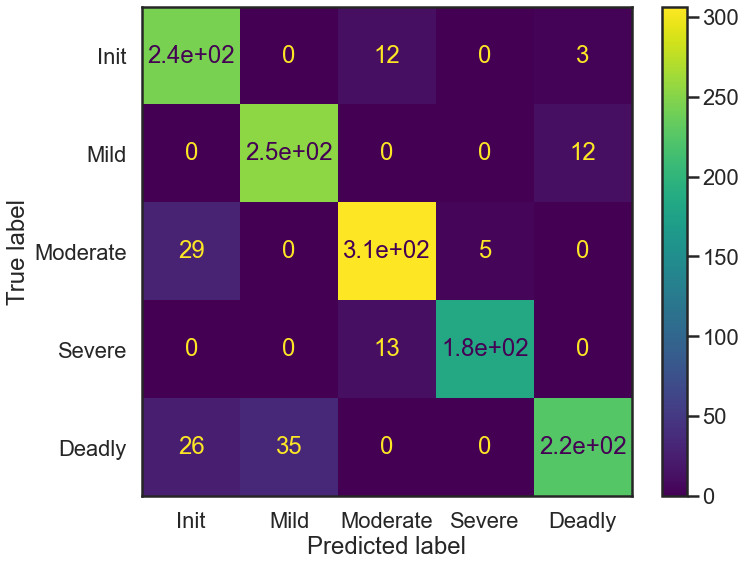

In [80]:
clf = KNeighborsClassifier(n_neighbors=3)
X = pd.concat([features_sme_df.iloc[:,:-5],ids_df["ringers"]], axis=1)
X_tra = pd.concat([X, ids_df], axis=1)
num_extra_cols = ids_df.shape[1]
y = sme_labels_kmeans

pred_df = run_eval(X, y, X_tra, clf)

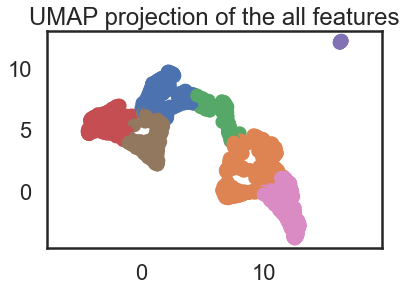

In [67]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=[sns.color_palette()[x] for x in results_df[y_col_name].to_list()])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of all features', fontsize=24);

In [165]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=4)
X = umap_df[["umap_0", "umap_1"]]
y = results_df["kmeans_5_target_all"]
skf.get_n_splits(X, y)

num_targets = 5

cm = np.zeros((num_targets, num_targets))
neigh = KNeighborsClassifier(n_neighbors=3)
pred_df = pd.DataFrame()
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    neigh.fit(X_train, y_train)

    y_hat = neigh.predict(X_test)
    cm += confusion_matrix(y_test, y_hat)
    y_hat_df = pd.DataFrame(index=test_index, data=y_hat, columns=["y_hat"])
    pred_df = pd.concat([pred_df, y_hat_df])
pred_df

,y_hat
0,1
1,1
2,1
3,1
4,1
...,...
1344,4
1345,4
1346,3
1347,3
